### Logistic Regression on Streptococcus pneumoniae

In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedGroupKFold, KFold

In [30]:
sp = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SP.csv')

/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_90570/1758425030.py:1: DtypeWarning: Columns (184337) have mixed types. Specify dtype option on import or set low_memory=False.
  sp = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SP.csv')


In [31]:
sp.shape

(596, 184338)

In [32]:
snp_columns = sp.filter(like='SNP')
snp_columns.shape

(596, 178618)

In [14]:
# Separate feature columns and target labels
X_noST = sp.drop(columns=['CHL',"TET","AZM","sample_ID","ST"], errors='ignore')

# Create individual datasets per antibiotic
# Split into features and labels
sp_chl = X_noST.copy()
sp_chl['label'] = sp['CHL']
y_noST_chl = sp_chl['label']

sp_tet = X_noST.copy()
sp_tet['label'] = sp['TET']
y_noST_tet = sp_tet['label']

sp_azm = X_noST.copy()
sp_azm['label'] = sp['AZM']
y_noST_azm = sp_azm['label']

### Classes Visualization

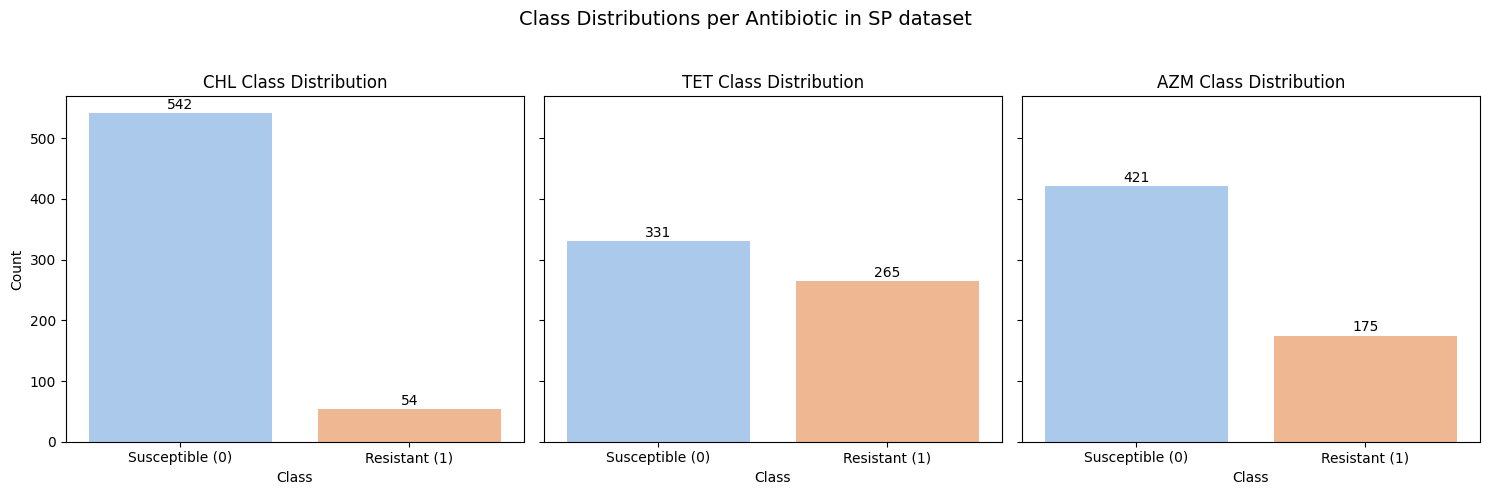

In [11]:
# Store your labels in a dictionary
labels_dict = {
    'CHL': y_noST_chl,
    'TET': y_noST_tet,
    'AZM': y_noST_azm
}

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot each antibiotic
for ax, (name, y) in zip(axes, labels_dict.items()):
    sns.countplot(x=y, palette='pastel', ax=ax, hue=y)
    ax.set_title(f"{name} Class Distribution", fontsize=12)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count" if name == 'CHL' else "")  # Only show y-axis on first
    ax.set_xticks([0, 1], ['Susceptible (0)', 'Resistant (1)'])
    ax.get_legend().remove()

    # Annotate counts
    for p in ax.patches:
        count = int(p.get_height())
        if count > 0:
            ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., count + 2),
                        ha='center', va='bottom', fontsize=10)


# Overall plot formatting
plt.suptitle("Class Distributions per Antibiotic in SP dataset", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


### Blocked cross-validation

In [5]:
# Creating dictionary of parameters to tune
hparam = {"C":[0.001, 0.01, 0.1, 1.00]}

# Drop label columns
features = sp.drop(columns=["CHL", "TET", "AZM", "sample_ID"], errors='ignore')

# drop rows with no numeric ST values
features['ST'] = pd.to_numeric(features['ST'], errors='coerce')  
features_clean_ST = features.dropna(subset=['ST'])

In [6]:
# Creating function to perform hyper parameter tuning of model
def LG_hp_tune(param, feat_train_df, lab_train, v=3, cv=4):
  #creating logistic regression model
  model = LogisticRegression(random_state = 42, max_iter=1000, class_weight='balanced')

  # isolating the features used for training
  feat = feat_train_df.drop(columns=["ST"])
  
  # Grouped cross-validation
  groups = feat_train_df['ST']
  cv = StratifiedGroupKFold(n_splits=4)
  gs = GridSearchCV(model, param, scoring='f1_macro',cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
  gs.fit(feat, lab_train, groups=groups)

  print(gs.best_params_)
  print(gs.best_score_)
  return gs.best_estimator_

##### 1. CHL

In [5]:
# Align labels with the cleaned features
labels_chl = sp.loc[features_clean_ST.index, 'CHL'] 

features_clean_ST['label'] = labels_chl

# Define X and y properly
X_chl = features_clean_ST.drop(columns=['label'])
y_chl = features_clean_ST['label']

# Split the data
X_train_chl, X_test_chl, y_train_chl, y_test_chl = train_test_split(
    X_chl, y_chl, stratify=y_chl, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled_chl_clean_ST, y_train_resampled_chl_clean_ST = smote.fit_resample(X_train_chl, y_train_chl)


/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_69694/2125258595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean_ST['label'] = labels_chl


In [10]:
LG_tuned_chl = LG_hp_tune(hparam, X_train_resampled_chl_clean_ST, y_train_resampled_chl_clean_ST)
bestC_chl = LG_tuned_chl.get_params()['C']

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ....C=0.001; f1_macro: (train=0.996, test=0.883) total time=   9.5s
[CV 2/4] END ....C=0.001; f1_macro: (train=1.000, test=0.868) total time=   8.4s
[CV 3/4] END ....C=0.001; f1_macro: (train=0.994, test=1.000) total time=   8.5s
[CV 4/4] END ....C=0.001; f1_macro: (train=0.993, test=1.000) total time=   9.0s
[CV 1/4] END .....C=0.01; f1_macro: (train=1.000, test=0.883) total time=   9.2s
[CV 2/4] END .....C=0.01; f1_macro: (train=1.000, test=0.854) total time=   8.2s
[CV 3/4] END .....C=0.01; f1_macro: (train=1.000, test=1.000) total time=   9.2s
[CV 4/4] END .....C=0.01; f1_macro: (train=1.000, test=1.000) total time=   9.1s
[CV 1/4] END ......C=0.1; f1_macro: (train=1.000, test=0.854) total time=   7.9s
[CV 2/4] END ......C=0.1; f1_macro: (train=1.000, test=0.840) total time=   7.9s
[CV 3/4] END ......C=0.1; f1_macro: (train=1.000, test=1.000) total time=   7.8s
[CV 4/4] END ......C=0.1; f1_macro: (train=1.000,

##### 2. TET

In [11]:
# Align labels with the cleaned features
labels_tet = sp.loc[features_clean_ST.index, 'TET'] 

features_clean_ST['label'] = labels_tet

# Define X and y properly
X_tet = features_clean_ST.drop(columns=['label'])
y_tet = features_clean_ST['label']

# Split the data
X_train_tet_clean_ST, X_test_tet_clean_ST, y_train_tet_clean_ST, y_test_tet_clean_ST = train_test_split(
    X_tet, y_tet, stratify=y_tet, test_size=0.3, random_state=42)

/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_69694/2011883875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean_ST['label'] = labels_tet


In [12]:
LG_tuned_tet = LG_hp_tune(hparam, X_train_tet_clean_ST, y_train_tet_clean_ST)
bestC_tet = LG_tuned_tet.get_params()['C']

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ....C=0.001; f1_macro: (train=0.985, test=0.882) total time=   2.3s
[CV 2/4] END ....C=0.001; f1_macro: (train=0.993, test=0.967) total time=   2.4s
[CV 3/4] END ....C=0.001; f1_macro: (train=0.986, test=0.909) total time=   2.2s
[CV 4/4] END ....C=0.001; f1_macro: (train=0.996, test=0.877) total time=   2.3s
[CV 1/4] END .....C=0.01; f1_macro: (train=1.000, test=0.936) total time=   1.9s
[CV 2/4] END .....C=0.01; f1_macro: (train=1.000, test=0.956) total time=   2.9s
[CV 3/4] END .....C=0.01; f1_macro: (train=1.000, test=0.932) total time=   3.0s
[CV 4/4] END .....C=0.01; f1_macro: (train=1.000, test=0.889) total time=   3.2s
[CV 1/4] END ......C=0.1; f1_macro: (train=1.000, test=0.936) total time=   1.9s
[CV 2/4] END ......C=0.1; f1_macro: (train=1.000, test=0.956) total time=   2.0s
[CV 3/4] END ......C=0.1; f1_macro: (train=1.000, test=0.943) total time=   2.0s
[CV 4/4] END ......C=0.1; f1_macro: (train=1.000,

##### 3. AZM

In [ ]:
# Align labels with the cleaned features
labels_azm = sp.loc[features_clean_ST.index, 'AZM'] 

features_clean_ST['label'] = labels_azm

# Define X and y properly
X_azm = features_clean_ST.drop(columns=['label'])
y_azm = features_clean_ST['label']

# Split the data
X_train_azm, X_test_azm, y_train_azm, y_test_azm = train_test_split(
    X_azm, y_azm, stratify=y_azm, test_size=0.3, random_state=42)

# smote
X_train_resampled_azm_clean_ST, y_train_resampled_azm_clean_ST = smote.fit_resample(X_train_azm, y_train_azm)


/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_69694/2470286663.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean_ST['label'] = labels_azm


In [14]:
LG_tuned_azm = LG_hp_tune(hparam, X_train_resampled_azm_clean_ST, y_train_resampled_azm_clean_ST)
bestC_azm = LG_tuned_azm.get_params()['C']

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ....C=0.001; f1_macro: (train=0.998, test=0.955) total time=   9.3s
[CV 2/4] END ....C=0.001; f1_macro: (train=0.993, test=0.912) total time=   8.7s
[CV 3/4] END ....C=0.001; f1_macro: (train=0.993, test=0.925) total time=   9.9s
[CV 4/4] END ....C=0.001; f1_macro: (train=0.992, test=1.000) total time=   8.8s
[CV 1/4] END .....C=0.01; f1_macro: (train=1.000, test=0.955) total time=   9.4s
[CV 2/4] END .....C=0.01; f1_macro: (train=1.000, test=0.937) total time=   9.2s
[CV 3/4] END .....C=0.01; f1_macro: (train=1.000, test=0.940) total time=  11.3s
[CV 4/4] END .....C=0.01; f1_macro: (train=1.000, test=1.000) total time=   8.1s
[CV 1/4] END ......C=0.1; f1_macro: (train=1.000, test=0.955) total time=   7.9s
[CV 2/4] END ......C=0.1; f1_macro: (train=1.000, test=0.937) total time=   9.3s
[CV 3/4] END ......C=0.1; f1_macro: (train=1.000, test=0.948) total time=   7.6s
[CV 4/4] END ......C=0.1; f1_macro: (train=1.000,

### Training with best C and testing

In [15]:
# Train-test split

X_train_chl, X_test_chl, y_train_chl, y_test_chl = train_test_split(
    X_noST, y_noST_chl, stratify= y_noST_chl, test_size=0.3, random_state=42)

X_train_tet, X_test_tet, y_train_tet, y_test_tet = train_test_split(
    X_noST, y_noST_tet, stratify= y_noST_tet, test_size=0.3, random_state=42)

X_train_azm, X_test_azm, y_train_azm, y_test_azm = train_test_split(
    X_noST, y_noST_azm, stratify= y_noST_azm, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_chl, y_train_resampled_chl = smote.fit_resample(X_train_chl, y_train_chl)
X_train_resampled_azm, y_train_resampled_azm = smote.fit_resample(X_train_azm, y_train_azm) 

print("CHL Resampled Class Distribution:", Counter(y_train_resampled_chl))
print("TET Class Distribution:", Counter(y_train_tet))
print("AZM Resampled Class Distribution:", Counter(y_train_resampled_azm))


CHL Resampled Class Distribution: Counter({0: 379, 1: 379})
TET Class Distribution: Counter({0: 232, 1: 185})
AZM Resampled Class Distribution: Counter({1: 295, 0: 295})


##### 1. CHL

Accuracy on test set: 0.9721
Accuracy on training set: 0.9908
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       163
           1       0.87      0.81      0.84        16

    accuracy                           0.97       179
   macro avg       0.92      0.90      0.91       179
weighted avg       0.97      0.97      0.97       179



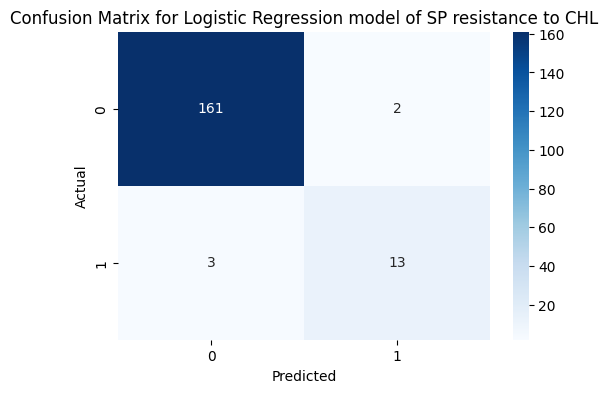

ROC-AUC on test set: 0.9310


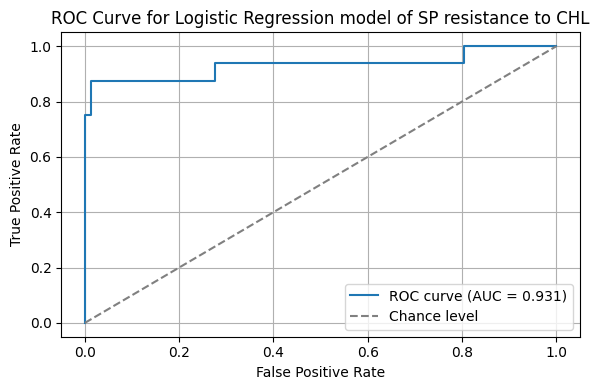

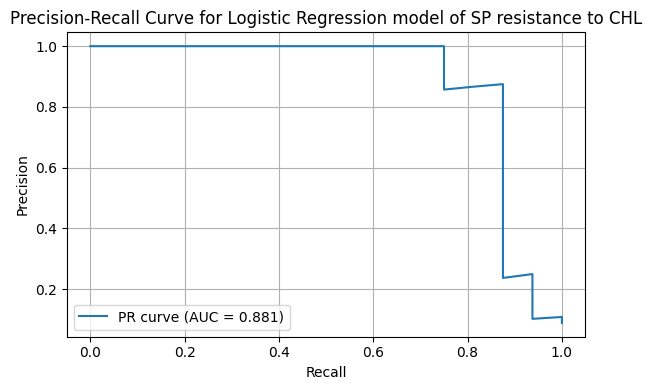

In [16]:
model_chl = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42, C=0.001)

# Train the model
model_chl.fit(X_train_resampled_chl, y_train_resampled_chl)

# Predictions
y_pred = model_chl.predict(X_test_chl)
y_train_pred = model_chl.predict(X_train_resampled_chl)

# Probabilities for ROC and PR curves
y_prob = model_chl.predict_proba(X_test_chl)[:, 1]  # Probability for the positive class

# Accuracy scores
print(f"Accuracy on test set: {accuracy_score(y_test_chl, y_pred):.4f}")
print(f"Accuracy on training set: {accuracy_score(y_train_resampled_chl, y_train_pred):.4f}")

# Classification report and confusion matrix
print(classification_report(y_test_chl, y_pred))
cm = confusion_matrix(y_test_chl, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression model of SP resistance to CHL")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test_chl, y_prob)
print(f"ROC-AUC on test set: {roc_auc:.4f}")

# Plot ROC-AUC Curve 
fpr, tpr, _ = roc_curve(y_test_chl, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Chance level')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression model of SP resistance to CHL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test_chl, y_prob)
pr_auc = average_precision_score(y_test_chl, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression model of SP resistance to CHL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### 2. TET

Accuracy on test set: 0.9665
Accuracy on training set: 1.0000
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        99
           1       0.97      0.95      0.96        80

    accuracy                           0.97       179
   macro avg       0.97      0.96      0.97       179
weighted avg       0.97      0.97      0.97       179



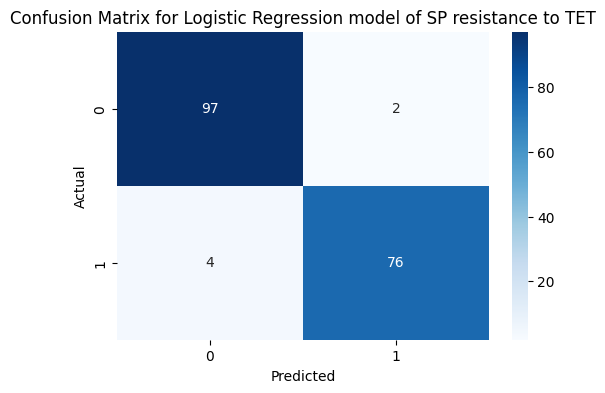

ROC-AUC on test set: 0.9970


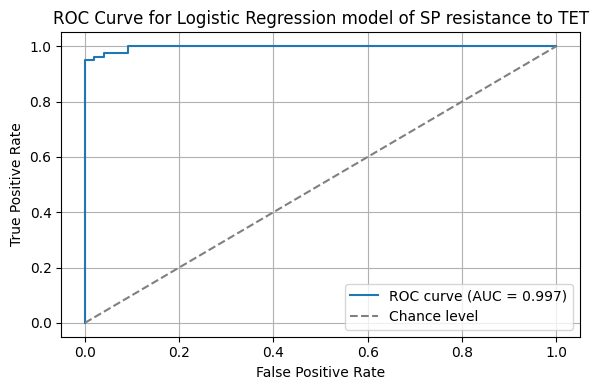

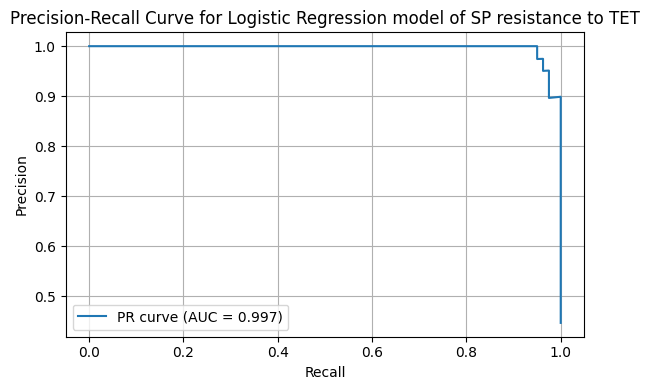

In [17]:
model_tet = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42, C=0.1)

# Train the model
model_tet.fit(X_train_tet, y_train_tet)

# Predictions
y_pred = model_tet.predict(X_test_tet)
y_train_pred = model_tet.predict(X_train_tet)

# Probabilities for ROC and PR curves
y_prob = model_tet.predict_proba(X_test_tet)[:, 1]  # Probability for the positive class

# Accuracy scores
print(f"Accuracy on test set: {accuracy_score(y_test_tet, y_pred):.4f}")
print(f"Accuracy on training set: {accuracy_score(y_train_tet, y_train_pred):.4f}")

# Classification report and confusion matrix
print(classification_report(y_test_tet, y_pred))
cm = confusion_matrix(y_test_tet, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression model of SP resistance to TET")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ROC-AUC score
roc_auc = roc_auc_score(y_test_tet, y_prob)
print(f"ROC-AUC on test set: {roc_auc:.4f}")

# Plot ROC-AUC Curve 
fpr, tpr, _ = roc_curve(y_test_tet, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Chance level')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression model of SP resistance to TET")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test_tet, y_prob)
pr_auc = average_precision_score(y_test_tet, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label="PR curve (AUC = {:.3f})".format(pr_auc))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression model of SP resistance to TET")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### 3. AZM

ROC-AUC on test set: 0.9973


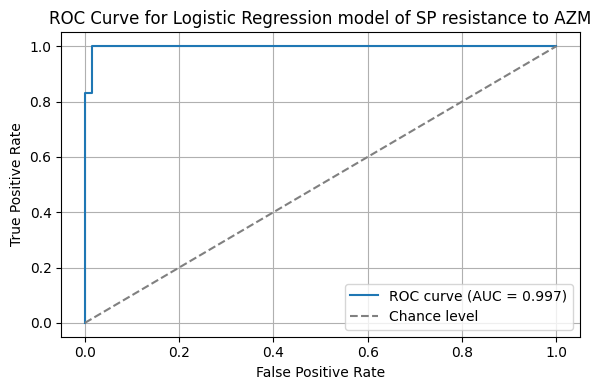

Accuracy on test set: 0.9441
Accuracy on training set: 1.0000
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       126
           1       0.96      0.85      0.90        53

    accuracy                           0.94       179
   macro avg       0.95      0.92      0.93       179
weighted avg       0.94      0.94      0.94       179



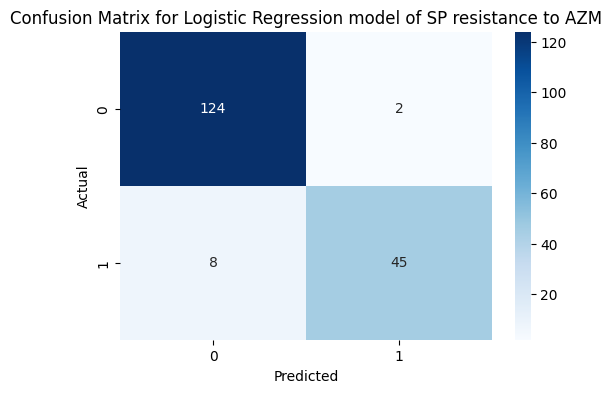

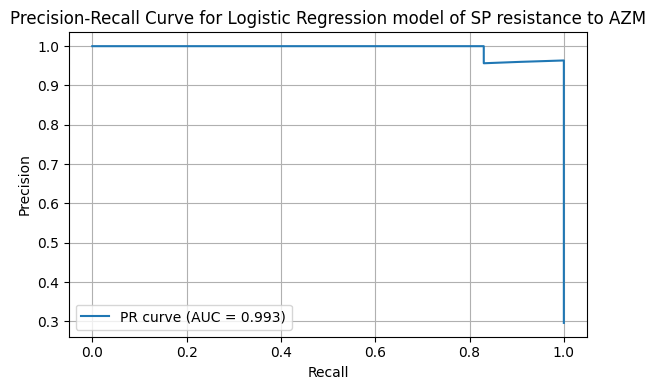

In [18]:
model_azm = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42, C=0.1)

# Train the model
model_azm.fit(X_train_resampled_azm, y_train_resampled_azm)

# Predictions
y_pred = model_azm.predict_proba(X_test_azm)[:, 1]
y_train_pred = model_azm.predict_proba(X_train_resampled_azm)[:, 1]

# Probabilities for ROC and PR curves
y_prob = model_azm.predict_proba(X_test_azm)[:, 1]  # Probability for the positive class

# ROC-AUC score
roc_auc = roc_auc_score(y_test_azm, y_prob)
print(f"ROC-AUC on test set: {roc_auc:.4f}")

# Plot ROC-AUC Curve 
fpr, tpr, _ = roc_curve(y_test_azm, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Chance level')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression model of SP resistance to AZM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Convert probabilities to binary predictions (default threshold = 0.5)
y_pred = (model_azm.predict_proba(X_test_azm)[:, 1] >= 0.5).astype(int)
y_train_pred = (model_azm.predict_proba(X_train_resampled_azm)[:, 1] >= 0.5).astype(int)

# Accuracy scores
print(f"Accuracy on test set: {accuracy_score(y_test_azm, y_pred):.4f}")
print(f"Accuracy on training set: {accuracy_score(y_train_resampled_azm, y_train_pred):.4f}")

# Classification report and confusion matrix
print(classification_report(y_test_azm, y_pred))
cm = confusion_matrix(y_test_azm, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression model of SP resistance to AZM") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Precision-Recall Curve 
precision, recall, _ = precision_recall_curve(y_test_azm, y_prob)
pr_auc = average_precision_score(y_test_azm, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label="PR curve (AUC = {:.3f})".format(pr_auc))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression model of SP resistance to AZM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Regression coefficients

##### 1. CHL

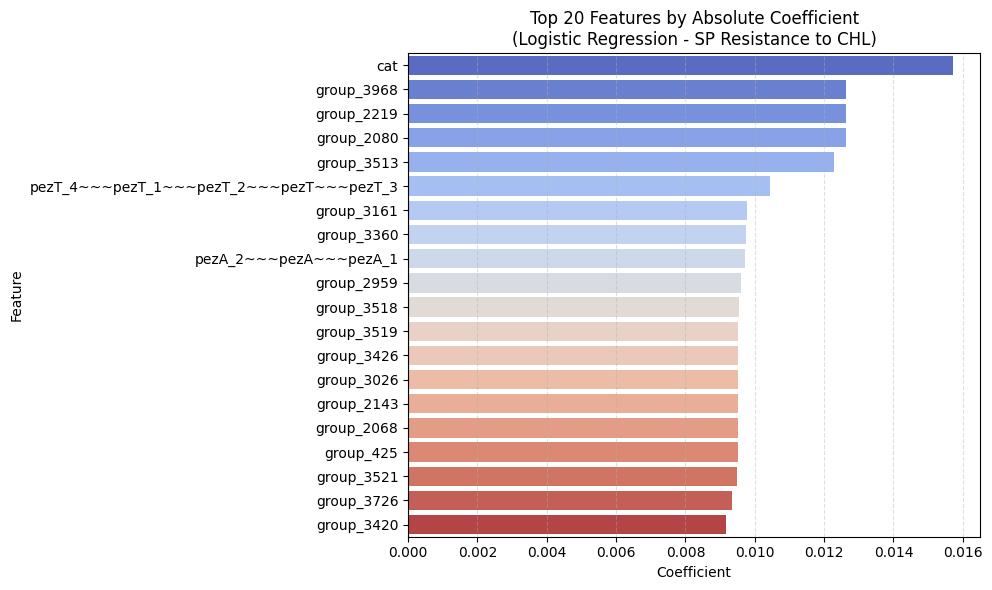

In [26]:
# Extract coefficients and feature names
coef = model_chl.coef_[0]
features = X_noST.columns

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'Odds Ratio': np.exp(coef),
    'Abs Coefficient': np.abs(coef)
})

# Sort by absolute coefficient value
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.grid(axis='x', linestyle='--', alpha=0.4)
sns.barplot(
    data=coef_df_sorted,
    y='Feature',
    x='Coefficient',
    palette='coolwarm',
    hue='Feature'
)
plt.axvline(0, color='gray', linestyle='--')

plt.title('Top 20 Features by Absolute Coefficient\n(Logistic Regression - SP Resistance to CHL)')
plt.tight_layout()
plt.show()


##### 2. TET

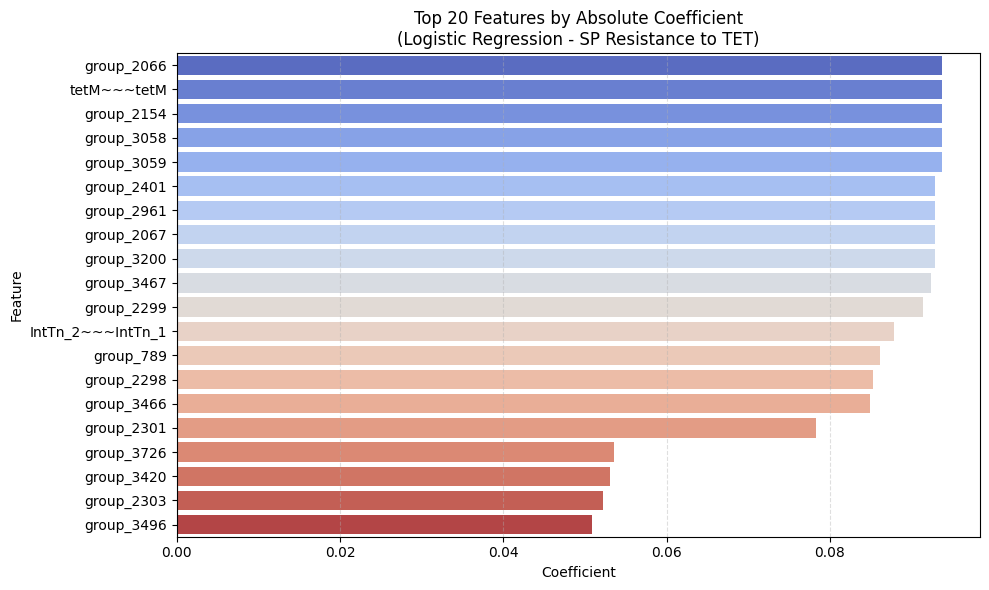

In [27]:
# Extract coefficients and feature names
coef = model_tet.coef_[0]
features = X_noST.columns

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'Odds Ratio': np.exp(coef),
    'Abs Coefficient': np.abs(coef)
})

# Sort by absolute coefficient value
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.grid(axis='x', linestyle='--', alpha=0.4)
sns.barplot(
    data=coef_df_sorted,
    y='Feature',
    x='Coefficient',
    palette='coolwarm',
    hue='Feature'
)
plt.axvline(0, color='gray', linestyle='--')

plt.title('Top 20 Features by Absolute Coefficient\n(Logistic Regression - SP Resistance to TET)')
plt.tight_layout()
plt.show()


##### 3. AZM

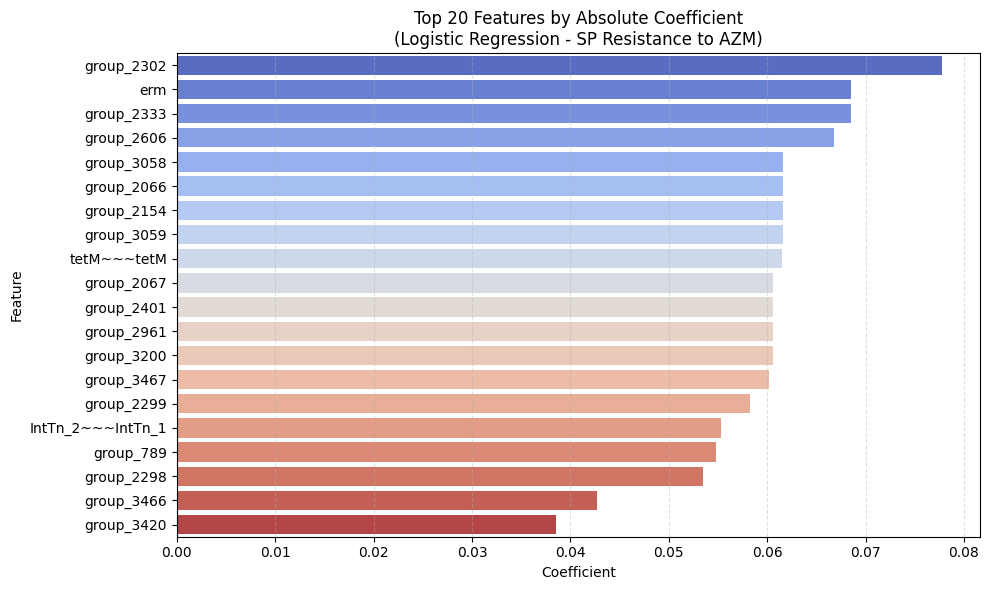

In [28]:
# Extract coefficients and feature names
coef = model_azm.coef_[0]
features = X_noST.columns

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'Odds Ratio': np.exp(coef),
    'Abs Coefficient': np.abs(coef)
})

# Sort by absolute coefficient value
coef_df_sorted = coef_df.sort_values(by='Abs Coefficient', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.grid(axis='x', linestyle='--', alpha=0.4)
sns.barplot(
    data=coef_df_sorted,
    y='Feature',
    x='Coefficient',
    palette='coolwarm',
    hue='Feature'
)
plt.axvline(0, color='gray', linestyle='--')

plt.title('Top 20 Features by Absolute Coefficient\n(Logistic Regression - SP Resistance to AZM)')
plt.tight_layout()
plt.show()
